In [6]:
import hierarchical_lda_ncrp
import numpy as np

## Simulation

In [5]:
def simulation(n):
    """simulate a corpus"""
    
    corpus = [[] for i in range(n)]
    for i in range(n):
        num_word = np.random.randint(100, 200, 1)[0]
        for j in range(num_word):
            char = np.random.normal(0, 1, num_word)
            word = str(int(round(char[j]*10)))
            corpus[i].append(word)
    return corpus

In [6]:
np.random.seed(2)
sim_corpus = simulation(50)
sim_hlda = hierarchical_lda_ncrp.hLDA(sim_corpus, 0.1, 0.01, 0.5, 0.01, 10, 3)

***LEVEL 0***

NODE 1: ['0', '3', '1']
 
***LEVEL 1***
NODE 1 : ['-1', '2', '-3']
NODE 2 : ['7']
 
***LEVEL 2***
NODE 1 : ['6', '-3', '-4']
NODE 2 : ['-9']
NODE 3 : ['21', '20', '-21']
NODE 4 : ['-1']


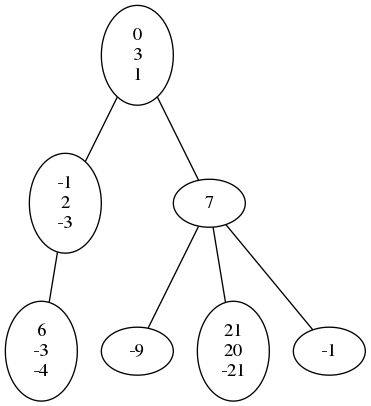

In [8]:
hierarchical_lda_ncrp.tree_plot(sim_hlda, num=3)

## Real data

In [9]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
with open("abstract.txt") as f:
    data = f.read()
    data = data.strip('\n')
    data_cleaned = data.split('\n\n')
    
cs = [",", ".", "’", "”", "“", "?", "!", ":", "\n", ";", "\\", "-", "—", "$", "/", "(", ")", "–", "[", "]"]
corpus = []
for i in range(len(data_cleaned)):
    data = data_cleaned[i]
    for x in cs:
        data = data.replace(x, '')
    word = data.lower().split(' ')
    no_stop = []
    for j in word:
        if j not in stop_words:
            no_stop.append(j)
    corpus.append(no_stop)

In [10]:
np.random.seed(2)
real_hlda = hierarchical_lda_ncrp.hLDA(corpus, 0.1, 0.01, 0.8, 0.01, 10, 3, 6)

***LEVEL 0***

NODE 1: ['repair', 'dna', 'growth', 'many', 'performance', 'cells']
 
***LEVEL 1***
NODE 1 : ['provide', 'learning', 'system', 'model', 'time', 'also']
NODE 2 : ['biological', 'dna', 'use', 'distribution', 'order', 'understanding']
NODE 3 : ['also', 'boolean', 'model', 'per', 'cells', 'expression']
NODE 4 : ['new', 'review', 'century', 'maker', 'information', 'two']
 
***LEVEL 2***
NODE 1 : ['learning', 'encouraging', 'end', 'methods', 'discussed', 'interferometer']
NODE 2 : ['research', 'applications', 'activity', 'economic', 'results', 'approaches']
NODE 3 : ['although', 'problems', 'due', 'heterogeneous', 'problem', 'learning']
NODE 4 : ['biology', 'sector', 'focus', 'organize', 'astronomical', 'model']
NODE 5 : ['nuclear', 'scale', 'issues', 'optimization', 'colors', 'michelson']
NODE 6 : ['dna', 'excision', 'api', 'explain', 'gp', 'limited']
NODE 7 : ['also', 'regression', 'parallax', 'stars', 'absorption', 'taking']
NODE 8 : ['resolution', 'using', 'damage', 'proce

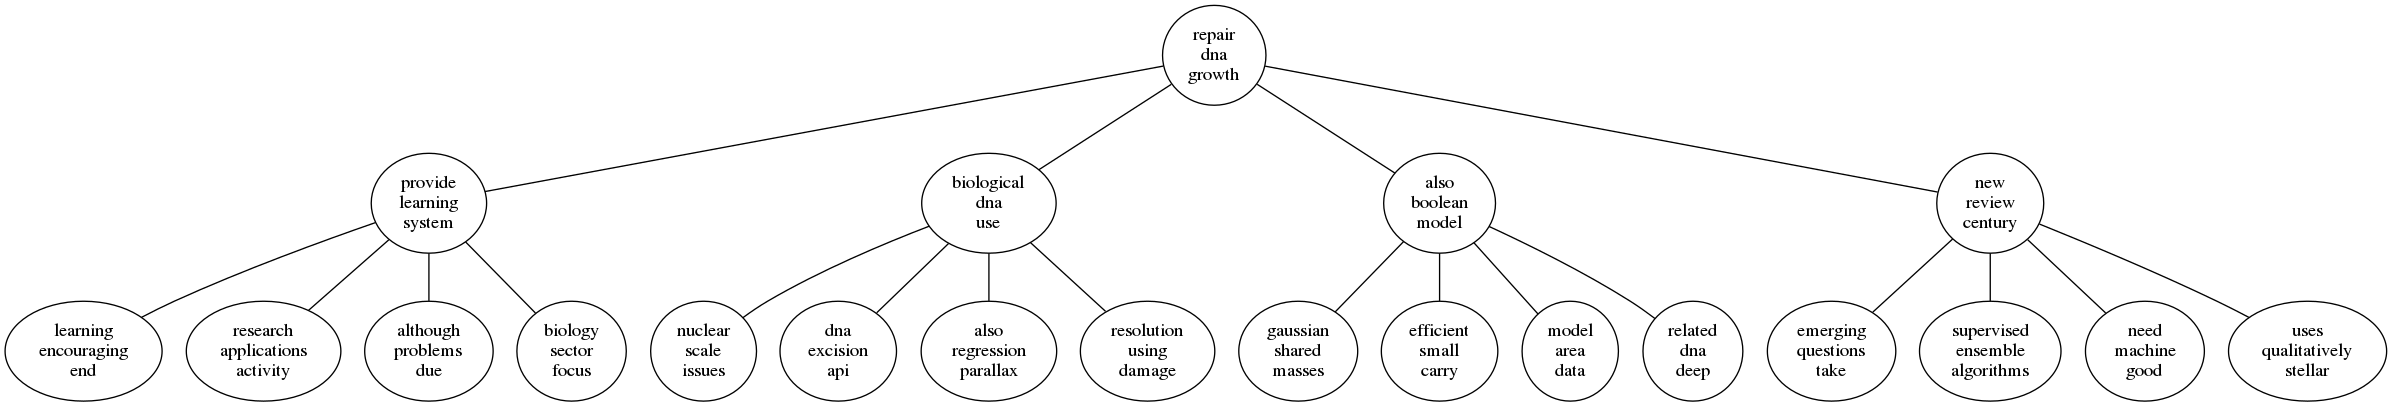

In [11]:
hierarchical_lda_ncrp.tree_plot(real_hlda, num=3)

## Optimization

In [1]:
import numpy as np
from scipy.special import gammaln
import random
from collections import Counter
import pickle
import matplotlib.pyplot as plt
import pydot
import itertools
import string

%load_ext Cython

In [2]:
%%cython --annotate

cimport cython
import cython
cimport numpy as np
import numpy as np
import itertools
import math
from scipy.special import gammaln

@cython.cdivision
@cython.boundscheck(False)
@cython.wraparound(False)

def CRP(topic, gamma):

    '''
    CRP: Chinese restaurant process results in an array of the probability, which represents
    the chance a new word gets assigned to different topics.
    
    Input:
    topic: a list of lists. In each sublist of topic, it contains corresponding assigned words. 
    gamma: double, a parameter for CRP.
    
    Output: 
    crp_p: a 1 * T array, where T is the number of topics.
    '''
    
    crp_p = np.zeros(len(topic)+1)
    M = 0
    for i in range(len(topic)):
        M += len(topic[i])
        
    for i in range(len(topic)+1):
        if i == 0:
            crp_p[i] = gamma / (gamma + M) 
        else:
            crp_p[i] = len(topic[i-1])/(gamma + M)
    return crp_p

def topic_sampling(corpus, gamma):
    
    """
    topic_sampling: samples t topics and returns a list of lists. 
    
    Input: 
    corpus: a list of lists, each sublist contains the word in the corresponding document
    gamma: paramter
    
    Output:
    topic: a list of lists, contains the assigned word in each topic
    """
    
    topic = []
    flat_words = list(itertools.chain.from_iterable(corpus))
    i = 0
    while i < len(flat_words):
        cm_prop = CRP(topic, gamma)/sum(CRP(topic, gamma))
        theta = np.random.multinomial(1,cm_prop).argmax()
        topic.append([flat_words[i]]) if theta == 0 else topic[theta-1].append(flat_words[i])
        i+=1
    return topic

def Z(corpus, T, alpha, beta):
    
    """
    Z samples from LDA model
    
    Input: 
    corpus: a list of lists, each sublist contains the word in the corresponding document
    topic: a list of lists, output of the topic_sampling
    alpha, beta: parameter
    
    Output: 
    z_topic: a list of lists, drawn from topic
    z_doc: a list of lists, record the document number of the word assigned to each topic
    """
   
    D = len(corpus)

    num_vocab = 0
    for i in range(D):
        num_vocab += len(corpus[i])
    z_topic=[[] for t in range(T)]
    z_doc=[[] for t in range(T)]
    dict = [[key,i] for i,c in enumerate(corpus) for j, key in enumerate(c)]  
    
    for e in dict:
        wi,i,j,p = e[0],e[1],0,np.zeros(T) 
        while j < T:
            lik=(z_topic[j].count(wi)+beta)/(len(z_topic[j]) +num_vocab*beta)
            pri=(np.sum(np.isin(z_topic[j],corpus[i]))+alpha)/(len(corpus[i]) +T*alpha)
            p[j]=lik * pri 
            j += 1
        i_top = np.random.multinomial(1, p/np.sum(p)).argmax()
        z_topic[i_top].append(wi)
        z_doc[i_top].append(i)
    
    return list(filter(None, z_topic)), list(filter(None, z_doc))

def CRP_prior(corpus, doc_topic, gamma):

    """
    CRP_prior: construct the prior
    
    Input:
    corpus: a list of lists, each sublist contains the word in the corresponding document
    doc_label: a list of lists, record the document number of the word assigned to each topic
    gamma: parameter
    
    Output: 
    doc_p: a D*T dimensional array, the probability of each topic for each document
    """
    
    doc_p = np.zeros((len(corpus), len(doc_topic)))
    for i in range(len(corpus)):
        doc = []
        for j in range(len(doc_topic)):
            doc_num = [num for num in doc_topic[j]]
            doc.append(doc_num)
        doc_p[i,:] = CRP(doc, gamma)[1:]
    return doc_p

def word_likelihood(corpus, topic, eta):
    
    """
    word_likelihood: calculate the likelihood given a particular choice of c
    
    Input: 
    corpus: a list of lists, each sublist contains the word in the corresponding document
    topic: a list of lists, obtained from Z function
    eta: parameter
    
    Output: 
    wm: a D*T array, where D is the number of documents and T is the number of topics
    """
    
    wm = np.zeros((len(corpus), len(topic)))
    
    W = 0
    for i in range(len(corpus)):
        W += len(corpus[i])
    
    for i in range(len(corpus)):
        doc = corpus[i]
        for j in range(len(topic)):
            l = topic[j]
            denom_1 = 1
            num_2 = 1
            
            n_cml_m = len(l) - len([w for w in set(doc) if w in l])
            num_1 = gammaln(n_cml_m + W * eta)
            denom_2 = gammaln(len(l) + W * eta)
            
            for word in doc:
                nw_cml_m = l.count(word) - doc.count(word)
                if nw_cml_m <= 0:
                    nw_cml_m = 0
                
                denom_1 += gammaln(nw_cml_m + eta)
                num_2 += gammaln(l.count(word) + eta)
            
            wm[i,j] = num_1 + num_2 - denom_1 - denom_2
        wm[i, :] = wm[i, :] + abs(min(wm[i, :]) + 0.1)
    wm = wm/wm.sum(axis = 1)[:, np.newaxis]
    return wm

cdef gibbs_sampling_cython(list corpus, int T, double alpha, double beta, double gamma, double eta, int ite):
    
    """
    gibbs sampling: posterior probability based on the CRP prior and word likelihood
    
    Input:
    corpus: a list of lists, each sublist contains the word in the corresponding document
    T: a list of lists, obtained from Z function
    alpha, beta, gamma, eta: parameter
    ite: number of iterations
    
    Output:
    w_topic: a list of lists, the distribution of words for topics
    """
    
    from collections import Counter
    
    cdef int num_vocab = 0
    cdef int i, it, n
    #cdef double[:,:] gibbs, c_m, doc_p, lik, pos
    #cdef double t2
    #cdef str word
    #cdef list doc_topic, doc, t, w_topic, w_doc
    
    num_vocab = np.sum([len(x) for x in corpus])
    gibbs = np.zeros((num_vocab, ite))
    
    
    for it in range(ite):
        doc_topic= Z(corpus, T, alpha, beta)[0]
        doc_p = CRP_prior(corpus, doc_topic, gamma)
        lik = word_likelihood(corpus, doc_topic, eta)
        c_m = (lik * doc_p) / (lik * doc_p).sum(axis = 1).reshape(-1,1) #posterior
        
        g=[]
        for i in range(len(corpus)):
            if np.sum(c_m[i,:-1])>1:
                c_m[i,:-1]=c_m[i,:-1]/np.sum(c_m[i,:-1])
                c_m[i,-1]=0
            for word in corpus[i]:
                p = np.random.multinomial(1, c_m[i])
                g.append(p.argmax())
        
        gibbs[:,it]=g
    
    t=[]
    for i in range(num_vocab):
        tt = int(Counter(gibbs[i,:]).most_common(1)[0][0])
        t.append(tt)
        
    n_topic=np.max(t)+1

    wn_topic = [[] for _ in range(n_topic)]
    
    n = 0
    for doc in corpus:
        wn_doc_topic = [[] for _ in range(n_topic)]
        for word in doc:
            k = t[n]
            wn_doc_topic[k].append(word)
            n += 1
        for i in range(n_topic):
            if len(wn_doc_topic[i]) != 0:
                k = wn_doc_topic[i]
                wn_topic[i].append(k)

    wn_topic = [x for x in wn_topic if x != []]
    return wn_topic

def hLDA_cython(corpus, alpha, beta, gamma, eta, ite, level,num=3):

    """
    hLDA generates an n*1 list of lists, where n is the number of level
    
    Input:
    corpus: a list of lists, contains words in each document
    alpha, beta, gamma, eta: parameter
    ite: number of iteration
    level: number of level
    
    Output:
    hLDA_tree: an n*1 list of lists
    node: an n*1 list of lists
    """
    
    cdef int j, it
    cdef list hLDA_tree, node_num
    from collections import Counter
    
    topic = topic_sampling(corpus, gamma)
    topic = len(topic)
    hLDA_tree = [[] for t in range(level)]
    node_num = [[] for t in range(level+1)]
    node_num[0].append(1)
    
    #print("***LEVEL 0***\n")
 
    # Initialize the tree:
    wn_topic = gibbs_sampling_cython(corpus, topic, alpha, beta, gamma, eta, ite)
    node_topic = sum(wn_topic[0],[])
    hLDA_tree[0].append(node_topic)
    #print_t = [i[0] for i in Counter(node_topic).most_common(num)]
    #print('NODE 1:',print_t)
    tmp_tree = wn_topic[1:]
    node_num[1].append(len(tmp_tree))
 
    for i in range(1, level): 
        #print(' ')
        #print("***LEVEL %d***" % i)
        it = sum(node_num[i])
        for j in range(it):
            if len(tmp_tree)==0:
                break
            wn_topic1 = gibbs_sampling_cython(tmp_tree[0], topic, alpha, beta, gamma, eta, ite)
            node_topic1 = [n for w in wn_topic1[0] for n in w]
            hLDA_tree[i].append(node_topic1)
            tmp_tree.remove(tmp_tree[0])
            #print_t = [i[0] for i in Counter(node_topic1).most_common(num)]
            #print('NODE',j+1,":",print_t)
            if wn_topic1[1:] != []: tmp_tree.extend(wn_topic1[1:]) 
            node_num[i+1].append(len(wn_topic1[1:]))
        #expand_hLDA_tree(tmp_tree, hLDA_tree, node_num, j, it)
    
    total_topic = sum([sum(i) for i in node_num[:level]])
    
    return hLDA_tree, node_num[:level]

In [4]:
corpus = [['flower', 'sky', 'table', 'carpet'], 
         ['mother', 'zoo', 'play'], 
         ['computer', 'seafood', 'engineer', 'idiot'], 
         ['student', 'Tom', 'Jerry', 'datafest']]

In [7]:
np.random.seed(4)
%timeit -r1 -n1 t1 = hLDA_cython(corpus, 0.1, 0.1, 2, 0.1, 10, 4, num = 5)
%timeit -r1 -n1 t2 = hierarchical_lda_ncrp.hLDA(corpus, 0.1, 0.1, 2, 0.1, 10, 4, num = 5)

125 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
***LEVEL 0***

NODE 1: ['sky', 'computer']
 
***LEVEL 1***
NODE 1 : ['seafood', 'engineer']
NODE 2 : ['idiot']
NODE 3 : ['student', 'Tom', 'Jerry', 'datafest']
 
***LEVEL 2***
NODE 1 : ['play']
NODE 2 : ['table', 'carpet']
NODE 3 : ['flower', 'zoo']
 
***LEVEL 3***
NODE 1 : ['mother']
154 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Comparison

In [12]:
# Comparative Analysis
from gensim.models import LdaModel, HdpModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel


def coherence_input(hlda_object):
    """
    return a list of lists for coherence
    
    input: output of the hlda function, which includes the tree and the index 
    
    output: a list of lists, sample a path
    """ 
    c_input = []
    tree = hlda_object[0]
    struc = hlda_object[1]
    n = 0
    idx = 0
    c_input.append(tree[0][0])
    
    for i in range(1, len(struc)):
        if struc[i][idx] == 0:
            break
        n = 0
        for j in range(idx):
            n += struc[i][j]
        idx = n + np.random.choice(struc[i][idx],1)[0]   
        c_input.append(tree[i][idx]) 
    return c_input


def hlda_coherence(hlda_object,dictionary,corpus,iterations):

    S = 0 
    n = 0
    for i in range(iterations):
        tes = coherence_input(hlda_object)
        cm_hlda = CoherenceModel(topics=tes, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        hlda_cohe = cm_hlda.get_coherence()
        if not np.isnan(hlda_cohe):
            n += 1 
            S += hlda_cohe
    
    avg = S/n
    return avg


def comp_analysis(corpus, hlda_object, n_topics = 10, iterations = 10000):
    
    dictionary2 = Dictionary(corpus)
    corpus2 = [dictionary2.doc2bow(text) for text in corpus]

    hdpmodel = HdpModel(corpus=corpus2, id2word=dictionary2)
    ldamodel = LdaModel(corpus=corpus2, num_topics=n_topics, id2word=dictionary2)
    cm_lda = CoherenceModel(model=ldamodel, corpus=corpus2, coherence='u_mass')
    cm_hdp = CoherenceModel(model=hdpmodel, corpus=corpus2, coherence='u_mass')
    
    lda_cohe = cm_lda.get_coherence()
    hdp_cohe = cm_hdp.get_coherence()
    hlda_cohe = hlda_coherence(hlda_object,dictionary2,corpus2,iterations=10000)
    
    print("Coherence for HLDA is %.2f" %hlda_cohe)
    print("Coherence for LDA is %.2f" %lda_cohe)
    print("Coherence for HDP is %.2f" %hdp_cohe)

In [15]:
comp_analysis(corpus, real_hlda, n_topics = 10, iterations = 1000)

Coherence for HLDA is -15.36
Coherence for LDA is -10.37
Coherence for HDP is -22.31
